In [1]:
# Import core
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt 
import re
import gc
import string
from IPython.core.interactiveshell import InteractiveShell

# Import custom
from datetime import datetime, timedelta
#from plotnine import *
from pandas.api.types import CategoricalDtype
#from plotnine.data import mpg
#%matplotlib inline

# Import NLTK related
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import ne_chunk, pos_tag
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams

# Import visualization
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot
import chart_studio.plotly.plotly as py
import cufflinks

# Import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Embedding, LSTM, SpatialDropout1D, Dropout
#from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Import web-related
from bs4 import BeautifulSoup

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [226]:
import psutil
psutil.virtual_memory()

svmem(total=17179869184, available=6603304960, percent=61.6, used=9448456192, free=1194704896, active=5408485376, inactive=5398806528, wired=4039970816)

# Definitions

In [20]:
# Remove digits from location data so we have "City, State" format
def remove_digits(df):
    """Remove digits from location"""
    df["Location_Clean"] = df["Location"].replace(to_replace = r'\d', value='', regex=True).str.rstrip()
    
    return df


# Create a day index which will be used to calcultate when the job was posted
def day_index(df):
    """Create a day index that represents how long ago the job was posted """
    
    df_dummy = pd.DataFrame()
    df_dummy["Day Index"] = df["Date"].str.split(" ", expand=True).get(0)
    df["Day Index"] = df_dummy["Day Index"].apply(lambda x: 0 if (x == 'Just' or x == 'Today') else x)
    
    return df

# Create variables representing the week date range and week index in which the job was posted
def week_posted(df):
    """Create a variable representing the week in which the job was posted"""
    conditions_date = [
        (df['Date Posted'] >= datetime(2020, 3, 4)) & (df['Date Posted'] <= datetime(2020, 3, 7)),
        (df['Date Posted'] >= datetime(2020, 3, 8)) & (df['Date Posted'] <= datetime(2020, 3, 14)),
        (df['Date Posted'] >= datetime(2020, 3, 15)) & (df['Date Posted'] <= datetime(2020, 3, 21)),
        (df['Date Posted'] >= datetime(2020, 3, 22)) & (df['Date Posted'] <= datetime(2020, 3, 28)),
        (df['Date Posted'] >= datetime(2020, 3, 29)) & (df['Date Posted'] <= datetime(2020, 4, 4)),
        (df['Date Posted'] >= datetime(2020, 4, 5)) & (df['Date Posted'] <= datetime(2020, 4, 11)),
        (df['Date Posted'] >= datetime(2020, 4, 12)) & (df['Date Posted'] <= datetime(2020, 4, 18))]
    
    conditions_index = [
        (df['Date Posted'] >= datetime(2020, 3, 4)) & (df['Date Posted'] <= datetime(2020, 3, 7)),
        (df['Date Posted'] >= datetime(2020, 3, 8)) & (df['Date Posted'] <= datetime(2020, 3, 14)),
        (df['Date Posted'] >= datetime(2020, 3, 15)) & (df['Date Posted'] <= datetime(2020, 3, 21)),
        (df['Date Posted'] >= datetime(2020, 3, 22)) & (df['Date Posted'] <= datetime(2020, 3, 28)),
        (df['Date Posted'] >= datetime(2020, 3, 29)) & (df['Date Posted'] <= datetime(2020, 4, 4)),
        (df['Date Posted'] >= datetime(2020, 4, 5)) & (df['Date Posted'] <= datetime(2020, 4, 11)),
        (df['Date Posted'] >= datetime(2020, 4, 12)) & (df['Date Posted'] <= datetime(2020, 4, 18))]
    
    
    
    choices_date = ['Mar 1 - Mar 7','Mar 8 - Mar 14', 'Mar 15 - Mar 21', 'Mar 22 - Mar 28', 'Mar 29 - Apr 4', 'Apr 5 - Apr 11', 'Apr 12 - Apr 18']
    choices_index = [0, 1, 2, 3, 4, 5, 6]

    df['Week Posted'] = np.select(conditions_date, choices_date)
    df['Week Index'] = np.select(conditions_index, choices_index)
    return df


## Import merged dataset

In [21]:
df_usa = pd.read_csv('df_usa_april_week3_merged_no30days.csv')

df_usa['As of Date'] = pd.to_datetime(df_usa['As of Date'])
df_usa['Date Posted'] = pd.to_datetime(df_usa['Date Posted'])

df_usa.head()
#df_usa.pipe(week_posted).head()

,Title,Location,Company,Rating,Salary,Sponsored,Date,As of Date,Description,Industry,Day Index,Date Posted,Week Posted,Week Index
0,Data Scientist Analyst,"Sunnyvale, CA",LOCKHEED MARTIN CORPORATION,4.0,None,None,2 days ago,2020-04-26,Perform exploratory research and analysis to i...,Datascience,2.0,2020-04-24,Apr 19 - Apr 25,7
1,"Data Science Intern (Summer, 2020)","Westfield Center, OH",Westfield Insurance,4.0,None,None,1 day ago,2020-04-26,"BUILD YOUR FUTURE, WHILE PROTECTING THEIRS.\nY...",Datascience,1.0,2020-04-25,Apr 19 - Apr 25,7
2,Data Science Intern,"San Diego, CA",HP,4.0,None,None,2 days ago,2020-04-26,Join us for a 12 week paid internship for the ...,Datascience,2.0,2020-04-24,Apr 19 - Apr 25,7
3,Data Scientist,Remote,Imperfect Foods,2.9,None,None,4 days ago,2020-04-26,About Imperfect\n\nImperfect Foods was founded...,Datascience,4.0,2020-04-22,Apr 19 - Apr 25,7
4,Data Scientist,"Richland, WA",Pacific Northwest National Laboratory,4.1,None,None,1 day ago,2020-04-26,Organization and Job ID\nJob ID: 310781\nDirec...,Datascience,1.0,2020-04-25,Apr 19 - Apr 25,7


## NLP on Job Description

In [ ]:
### 5 - Description
#sents = sent_tokenize(df1["Description"][1])
#words = word_tokenize(df1["Description"][1])

In [23]:
def lower_tokens(df):
    """Convert descriptions to lower case and then tokenize them"""
    description_lower = df["Description"].apply(lambda x: x.lower())
    df["Tokens"] = description_lower.apply(lambda x: nltk.word_tokenize(x))    
    return df

def sentence(df):
    description_lower = df["Description"].apply(lambda x: x.lower())
    df["Sentence"] = description_lower.apply(lambda x: sent_tokenize(x))
    return df

In [24]:
# Takes about Duration: 0:00:59.713260
df_usa.pipe(lower_tokens).head(1)

,Title,Location,Company,Rating,Salary,Sponsored,Date,As of Date,Description,Industry,Day Index,Date Posted,Week Posted,Week Index,Tokens
0,Data Scientist Analyst,"Sunnyvale, CA",LOCKHEED MARTIN CORPORATION,4.0,None,None,2 days ago,2020-04-26,Perform exploratory research and analysis to i...,Datascience,2.0,2020-04-24,Apr 19 - Apr 25,7,"[perform, exploratory, research, and, analysis..."


In [15]:
# Takes about Duration: 0:00:15
df_usa.pipe(sentence).head(1)

,Title,Location,Company,Rating,Salary,Sponsored,Date,As of Date,Description,Industry,Day Index,Date Posted,Week Posted,Week Index,Tokens,Sentence
0,Data Scientist Analyst,"Sunnyvale, CA",LOCKHEED MARTIN CORPORATION,4.0,None,None,2 days ago,2020-04-26,Perform exploratory research and analysis to i...,Datascience,2.0,2020-04-24,Apr 19 - Apr 25,7,"[perform, exploratory, research, and, analysis...",[perform exploratory research and analysis to ...


In [16]:
skills_df = df_usa.filter(items=["Title", "Location", "Company", "Industry", "Sentence", "Description"])
skills_df.head(1)

,Title,Location,Company,Industry,Sentence,Description
0,Data Scientist Analyst,"Sunnyvale, CA",LOCKHEED MARTIN CORPORATION,Datascience,[perform exploratory research and analysis to ...,Perform exploratory research and analysis to i...


In [25]:
skills_df["sent_skills"] = ""

for i in skills_df.index:
    sentence = skills_df["Sentence"][i]
    
    for line in sentence:
        skills = []
        if "skills" in line:
            skills.append(line)
            skills_df["sent_skills"][i] = ' '.join(map(str, skills))
        
skills_df.head(1)

,Title,Location,Company,Industry,Sentence,Description,sent_skills
0,Data Scientist Analyst,"Sunnyvale, CA",LOCKHEED MARTIN CORPORATION,Datascience,[perform exploratory research and analysis to ...,Perform exploratory research and analysis to i...,desired skills:\npython\nc++\ndata engineering...


In [11]:
def lower_tokens(df):
    """Convert descriptions to lower case and then tokenize them"""
    df["Tokens"] = skills_df["sent_skills"].apply(lambda x: nltk.word_tokenize(x))
    
    return df

In [26]:
skills_df.pipe(lower_tokens).head(1)

,Title,Location,Company,Industry,Sentence,Description,sent_skills,Tokens
0,Data Scientist Analyst,"Sunnyvale, CA",LOCKHEED MARTIN CORPORATION,Datascience,[perform exploratory research and analysis to ...,Perform exploratory research and analysis to i...,desired skills:\npython\nc++\ndata engineering...,"[perform, exploratory, research, and, analysis..."


In [29]:
punctuation = string.punctuation 
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
start_time = datetime.now()

stop_words=set(stopwords.words('english'))

skills_df["Tokens_wo_stop"] = ""

for i in skills_df.index:
    filtered_sent = []
    for w in skills_df["Tokens"][i]:        
        if w not in stop_words:
            filtered_sent.append(w)
            skills_df["Tokens_wo_stop"][i] = filtered_sent
            
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:32:14.360956


In [32]:
def skills_tokens (df):
    total_skills = total_skills + df["Tokens_wo_stop"]
    return total_skills

In [33]:
statistics=['statistical models','statistical modeling','probability','normal distribution','poisson distribution',
            'survival models','hypothesis testing','bayesian testing','factor analysis','forecasting',
           'markov chain','monte carlo']

machine_learning=['machine learning', 'regression', 'classification', 'clustering', 'logistic', 'K means', 'random forest', 'xgboost', 'svm', 
                 'naive bayes', 'pca', 'decision trees', 'svd', 'ensemble models', 'boltzman machine']

data_engineering=['aws', 'ec2','spark','s3','docker','kubernetes','scala','teradata','google big query',
                  'hive','hadoop','sql']

deep_learning=['neural', 'keras','theano','face detection','convolutional','object detection','yolo','gpu','cuda',
                  'tensorflow','lstm','gan', 'opencv']

r_language=['r', 'ggplot','shiny','cran','dplyr','tidyr','lubridate','knitr']
            
python_language=['python', 'flask','django','pandas','numpy','skitlearn','sklearn','matplotlib',
                'scipy', 'bokeh','statsmodel']

nlp=['nlp', 'lda','lsi','spacy','nltk']
            

# Start the new model from here. Work only with datascience jobs

In [37]:
df_ds = df_usa.copy()[df_usa["Industry"] == "Datascience"]
df_ds.head(1)

,Title,Location,Company,Rating,Salary,Sponsored,Date,As of Date,Description,Industry,Day Index,Date Posted,Week Posted,Week Index,Tokens
0,Data Scientist Analyst,"Sunnyvale, CA",LOCKHEED MARTIN CORPORATION,4.0,None,None,2 days ago,2020-04-26,Perform exploratory research and analysis to i...,Datascience,2.0,2020-04-24,Apr 19 - Apr 25,7,"[perform, exploratory, research, and, analysis..."


In [35]:
## Functions

punctuation = '!"#$%\'()*,-:;<=>?@[\\]^_`{|}~'

def sentence(df, target_column):
    description_clean = df[target_column].apply(lambda x: x.replace("\n", " "))
    description_lower = description_clean.apply(lambda x: x.lower())
    description_lower_no_punctuation = description_lower.apply(lambda x: x.translate(str.maketrans('', '', punctuation)))
    df["Sentence"] = description_lower_no_punctuation.apply(lambda x: sent_tokenize(x))
    return df

In [38]:
df_ds.pipe(sentence(df_ds, "Description")).head(1)

TypeError: 'DataFrame' object is not callable

## Chunk each sentence

In [39]:
tokenized = []
for i in df_ds.index:
    tokenized = tokenized + df_ds.Sentence[i]
    
tokenized[0]

'perform exploratory research and analysis to identify novel and meaningful patterns in data and uses statistical methods to reject or accept proposed hypotheses about relationships or latent predictive factors discovered through their work to provide business value.'

In [42]:
chunking_list = []
def chunking():
    
    start_time = datetime.now()
        
    try:
        for i in tokenized:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            
            chunkGram = r"""Chunk: {<NN.*>+}"""
            
            chunkParser = nltk.RegexpParser(chunkGram)
            chunked = chunkParser.parse(tagged)
            for subtree in chunked.subtrees():
                if subtree.label() == 'Chunk': 
                    chunking_list.append(subtree)
                    #print(subtree)
                    
    except Exception as e:
        print(str(e))

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
        
chunking()

Duration: 0:00:58.025299


In [157]:
df_chunk = pd.DataFrame(chunking_list)
print(df_chunk.shape)

(220680, 17)


## Investigate chunk data

In [158]:
#df_chunk = pd.read_csv("datascience_chunks_may16.csv")
df_chunk.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"(research, NN)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [159]:
df_chunk_v2 = df_chunk.copy()[df_chunk[5].isna() == True]
df_chunk_v2.shape

(219227, 17)

In [160]:
df_chunk_v2 = df_chunk_v2.drop(columns = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
df_chunk_v2.head(1)

,0,1,2,3,4
0,"(research, NN)",None,None,None,None


In [47]:
def clean_chunk_data(df):
        """Convert df_chunk variables into correct format"""
        df["word_1"] = df[0].apply(lambda x: '' if x is None else x[0])
        df["word_2"] = df[1].apply(lambda x: '' if x is None else x[0])
        df["word_3"] = df[2].apply(lambda x: '' if x is None else x[0])
        df["word_4"] = df[3].apply(lambda x: '' if x is None else x[0])
        df["word_5"] = df[4].apply(lambda x: '' if x is None else x[0])
        #df["word_6"] = df[5].apply(lambda x: '' if x is None else x[0])
        #df["word_7"] = df[6].apply(lambda x: '' if x is None else x[0])
        #df["word_8"] = df[7].apply(lambda x: '' if x is None else x[0])
        #df["word_9"] = df[8].apply(lambda x: '' if x is None else x[0])
        
        df["combined_words"] = df["word_1"] + ' ' + df["word_2"] + ' ' + df["word_3"] + ' ' + df["word_4"] + ' ' + df["word_5"]
        df["combined_words"] = df["combined_words"].str.rstrip()
        return df 

In [161]:
df_chunk_v2.pipe(clean_chunk_data).head(1)

,0,1,2,3,4,word_1,word_2,word_3,word_4,word_5,combined_words
0,"(research, NN)",None,None,None,None,research,,,,,research


In [162]:
df_chunk_no_dups = df_chunk_v2.copy().drop(columns = [0, 1, 2, 3, 4]).drop_duplicates()

print(df_chunk_no_dups.shape)

(35701, 6)


In [149]:
df_chunk_training_1000 = df_chunk_no_dups.copy().sample(n = 1000) 
df_chunk_training_1000.shape

(1000, 6)

In [150]:
df_chunk_training_1000[:5]

,word_1,word_2,word_3,word_4,word_5,combined_words
186693,click,data,subscription,,,click data subscription
204857,shippers,,,,,shippers
198579,ssis,sas,powerbi,,,ssis sas powerbi
13615,patients,family,members,visitors,,patients family members visitors
16936,environment,s3,,,,environment s3


In [ ]:
#df_chunk_training_1000.to_csv("df_chunk_unique_part2_may16.csv")

## Import all data science chunks

In [165]:
#df_chunk = pd.read_csv("datascience_chunks_may16.csv")

df_tagged_chunk_0_to_1000 = pd.read_csv("df_chunk_unique_may16_tagged.csv", usecols = ["combined_words", "Technical", "Soft"])
df_tagged_chunk_1001_to_2000 = pd.read_csv("df_chunk_unique_part2_may16_tagged.csv", usecols = ["combined_words", "Technical", "Soft"])
df_tagged_chunk = df_tagged_chunk_0_to_1000.append(df_tagged_chunk_1001_to_2000).reset_index().drop(columns = ('index'))

df_tagged_chunk.head(1)

,combined_words,Technical,Soft
0,business cases experience,0,1


In [167]:
df_chunk_tech_1 = df_tagged_chunk[df_tagged_chunk["Technical"] == 1]
df_chunk_tech_0 = df_tagged_chunk[df_tagged_chunk["Technical"] == 0].sample(n=598, random_state=1)

df_chunk_tech = df_chunk_tech_1.append(df_chunk_tech_0).sample(frac = 1).reset_index(drop = True)
df_chunk_tech.head(1)

,combined_words,Technical,Soft
0,source data stores,1,0


In [168]:
df_chunk_tech.shape

(1196, 3)

# Word embeddings model

In [213]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(df_chunk_tech["combined_words"], df_chunk_tech["Technical"], test_size=0.1, random_state=42)
X_train_tech.shape
X_test_tech.shape
X_train_tech[:2]

(1076,)

(120,)

943    output routines
906       agronÃ³micos
Name: combined_words, dtype: object

In [211]:
vocab_size = 2000
encoded_docs_train_tech = [one_hot(d, vocab_size) for d in X_train_tech]
encoded_docs_train_tech[0:2]

[[517, 1271], [195]]

In [177]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_tech = pad_sequences(encoded_docs_train_tech, maxlen=max_length, padding='post')
print(padded_docs_train_tech[:5])

[[ 517 1271    0    0    0]
 [ 195    0    0    0    0]
 [ 445   57    0    0    0]
 [1716  217    0    0    0]
 [1462    0    0    0    0]]


In [63]:
encoded_docs_test_tech = [one_hot(d, vocab_size) for d in X_test_tech]

padded_docs_test_tech = pad_sequences(encoded_docs_test_tech, maxlen=max_length, padding='post')
#print(padded_docs_test)

In [178]:
# define the model
embeddings_model = Sequential()
embeddings_model.add(Embedding(vocab_size, 10, input_length=max_length))
embeddings_model.add(Flatten())
embeddings_model.add(Dense(1, activation='sigmoid'))

In [181]:
# compile the model
embeddings_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(embeddings_model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 5, 10)             20000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 20,051
Trainable params: 20,051
Non-trainable params: 0
_________________________________________________________________
None


In [182]:
# fit the model
embeddings_model.fit(padded_docs_train_tech, y_train_tech, epochs=20, verbose=0)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



In [183]:
model_tech = embeddings_model.fit(padded_docs_train_tech, y_train_tech, epochs=25, validation_data = (padded_docs_test_tech, y_test_tech), verbose=2)

Train on 1076 samples, validate on 120 samples
Epoch 1/25
 - 0s - loss: 0.2185 - accuracy: 0.9638 - val_loss: 1.0456 - val_accuracy: 0.5333
Epoch 2/25
 - 0s - loss: 0.2049 - accuracy: 0.9703 - val_loss: 1.0782 - val_accuracy: 0.5250
Epoch 3/25
 - 0s - loss: 0.1924 - accuracy: 0.9740 - val_loss: 1.1106 - val_accuracy: 0.5250
Epoch 4/25
 - 0s - loss: 0.1809 - accuracy: 0.9758 - val_loss: 1.1432 - val_accuracy: 0.5083
Epoch 5/25
 - 0s - loss: 0.1702 - accuracy: 0.9805 - val_loss: 1.1773 - val_accuracy: 0.5083
Epoch 6/25
 - 0s - loss: 0.1604 - accuracy: 0.9823 - val_loss: 1.2097 - val_accuracy: 0.5083
Epoch 7/25
 - 0s - loss: 0.1515 - accuracy: 0.9842 - val_loss: 1.2403 - val_accuracy: 0.5083
Epoch 8/25
 - 0s - loss: 0.1433 - accuracy: 0.9842 - val_loss: 1.2737 - val_accuracy: 0.5083
Epoch 9/25
 - 0s - loss: 0.1356 - accuracy: 0.9851 - val_loss: 1.3053 - val_accuracy: 0.5167
Epoch 10/25
 - 0s - loss: 0.1288 - accuracy: 0.9861 - val_loss: 1.3374 - val_accuracy: 0.5167
Epoch 11/25
 - 0s - lo

In [68]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9926
Testing Accuracy:  0.5000


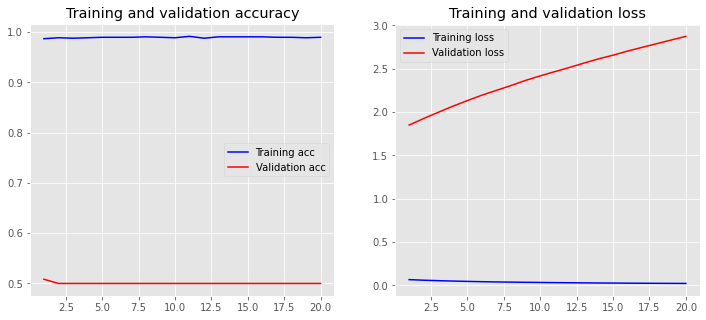

In [184]:
test_sample = "analytical skills"

history = embeddings_model.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

loss, accuracy = embeddings_model.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [70]:
#model.save('CNN_test_may18_10pct.model')

## Test model prediction

In [185]:
prediction_tech = embeddings_model.predict(padded_docs_test_tech)

In [186]:
df_tech= pd.DataFrame(X_test_tech)
df_tech["skill_tech"] = y_test_tech
df_tech["prediction"] = prediction_tech.round(0)
df_tech.shape

(120, 3)

In [187]:
df_tech.head(5)

,combined_words,skill_tech,prediction
636,data analysis problem,0,1.0
243,value ideas,0,0.0
1013,cross sell engines,1,1.0
1113,advice collaborates,0,1.0
58,analysis libraries,1,1.0


In [188]:
actual_values = df_tech.skill_tech.values
predicted_values = df_tech.prediction.values.astype(int)

predicted_values

array([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0])

In [189]:
confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

[[26 31]
 [29 34]]


## Second version of model: 80 vs 20 split

In [ ]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(df_chunk_tech["combined_words"], df_chunk_tech["Technical"], test_size=0.2, random_state=42)
X_train_tech.shape

vocab_size = 2000
encoded_docs_train_tech = [one_hot(d, vocab_size) for d in X_train_tech]

# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_tech = pad_sequences(encoded_docs_train_tech, maxlen=max_length, padding='post')
print(padded_docs_train_tech)

encoded_docs_test_tech = [one_hot(d, vocab_size) for d in X_test_tech]

padded_docs_test_tech = pad_sequences(encoded_docs_test_tech, maxlen=max_length, padding='post')
#print(padded_docs_test)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs_train_tech, y_train_tech, epochs=20, verbose=0)

model_tech_v2 = model.fit(padded_docs_train_tech, y_train_tech, epochs=25, 
                          validation_data = (padded_docs_test_tech, y_test_tech), verbose=2)

#model.save('CNN_test_may18_12pct.model')

prediction_tech_v2 = model.predict(padded_docs_test_tech)

df_tech_v2= pd.DataFrame(X_test_tech)
df_tech_v2["skill_tech"] = y_test_tech
df_tech_v2["prediction"] = prediction_tech_v2.round(0)
df_tech_v2.shape

actual_values_v2 = df_tech_v2.skill_tech.values
predicted_values_v2 = df_tech_v2.prediction.values.astype(int)

confusion_v2 = confusion_matrix(actual_values_v2, predicted_values_v2)
print(confusion_v2)

# Embeddings Layer parameter changes (Real Python website test)

In [193]:
embedding_dim = 50
maxlen = 5


embeddings_model_v1 = Sequential()
embeddings_model_v1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
embeddings_model_v1.add(layers.Flatten())
embeddings_model_v1.add(layers.Dense(10, activation='relu'))
embeddings_model_v1.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 5, 50)             100000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2510      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 102,521
Trainable params: 102,521
Non-trainable params: 0
_________________________________________________________________


In [194]:
history = embeddings_model_v1.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



train_teching Accuracy: 0.9944
Testing Accuracy:  0.5167


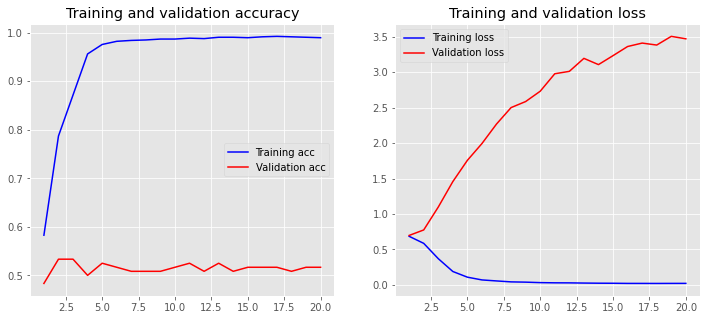

In [195]:
loss, accuracy = embeddings_model_v1.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v1.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Real Python website test version 2 model

In [196]:
embeddings_model_v2 = Sequential()
embeddings_model_v2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
embeddings_model_v2.add(layers.GlobalMaxPool1D())
embeddings_model_v2.add(layers.Dense(10, activation='relu'))
embeddings_model_v2.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 5, 50)             100000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 100,521
Trainable params: 100,521
Non-trainable params: 0
_________________________________________________________________


In [197]:
history_v2 = embeddings_model_v2.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



train_teching Accuracy: 0.9944
Testing Accuracy:  0.5333


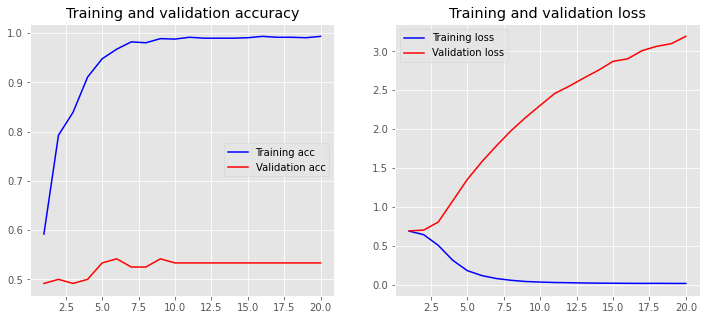

In [198]:
loss, accuracy = embeddings_model_v2.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v2.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_v2)

In [199]:
prediction_tech_v2 = embeddings_model_v2.predict(padded_docs_test_tech)

df_tech_v2= pd.DataFrame(X_test_tech)
df_tech_v2["skill_tech"] = y_test_tech
df_tech_v2["prediction"] = prediction_tech_v2.round(0)

actual_values_v2 = df_tech_v2.skill_tech.values
predicted_values_v2 = df_tech_v2.prediction.values.astype(int)

confusion_v2 = confusion_matrix(actual_values_v2, predicted_values_v2)
print(confusion_v2)

[[30 27]
 [29 34]]


## Real python test v3

In [223]:
embedding_dim = 5

embeddings_model_v3 = Sequential()
embeddings_model_v3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
embeddings_model_v3.add(layers.Conv1D(128, 5, activation='relu'))
embeddings_model_v3.add(layers.GlobalMaxPooling1D())
embeddings_model_v3.add(layers.Dense(10, activation='relu'))
embeddings_model_v3.add(layers.Dense(1, activation='sigmoid'))
embeddings_model_v3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
embeddings_model_v3.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 5, 5)              10000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 128)            3328      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 14,629
Trainable params: 14,629
Non-trainable params: 0
_________________________________________________________________


In [224]:
history_v3 = embeddings_model_v3.fit(padded_docs_train_tech, y_train_tech,
                    epochs=20,
                    verbose=False,
                    validation_data=(padded_docs_test_tech, y_test_tech),
                    batch_size=10)

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



train_teching Accuracy: 0.9935
Testing Accuracy:  0.5083


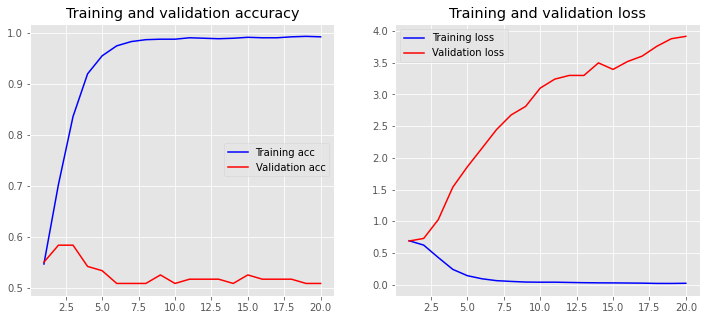

In [225]:
loss, accuracy = embeddings_model_v3.evaluate(padded_docs_train_tech, y_train_tech, verbose=False)
print("train_teching Accuracy: {:.4f}".format(accuracy))
loss, accuracy = embeddings_model_v3.evaluate(padded_docs_test_tech, y_test_tech, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_v3)

In [203]:
prediction_tech_v3 = embeddings_model_v3.predict(padded_docs_test_tech)

df_tech_v3= pd.DataFrame(X_test_tech)
df_tech_v3["skill_tech"] = y_test_tech
df_tech_v3["prediction"] = prediction_tech_v3.round(0)

actual_values_v3 = df_tech_v3.skill_tech.values
predicted_values_v3 = df_tech_v3.prediction.values.astype(int)

confusion_v3 = confusion_matrix(actual_values_v3, predicted_values_v3)
print(confusion_v3)

[[30 27]
 [30 33]]


## LSTM Test

In [89]:
STOPWORDS = set(stopwords.words('english'))

InteractiveShell.ast_node_interactivity = 'all'

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [90]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000

MAX_SEQUENCE_LENGTH = 5

# This is the size of the vector space in which words will be embedded. 
# It defines the size of the output vectors from this layer for each word. 
EMBEDDING_DIM = 5

# This is the length of input sequences. 
#For example, if all of your input documents are comprised of 1000 words, this would be 1000.
INPUT_LENGTH = 5

max_len = 1

In [204]:
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=5, dropout=0.2))
lstm_model.add(SpatialDropout1D(0.2))

lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(max_len))
lstm_model.add(Activation('relu'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

lstm_model.summary()

/Users/pavel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 5, 5)              1250000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 5, 5)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 1,292,501
Trainable params: 1,292,501
Non-trainable params: 0
_________________________________________________________________


In [205]:
history = lstm_model.fit(padded_docs_train_tech, y_train_tech, epochs=10, batch_size=5 ,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.

/Users/pavel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 860 samples, validate on 216 samples
Epoch 1/10
860/860 [==============================] - 3s 4ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278
Epoch 2/10
860/860 [==============================] - 2s 3ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278
Epoch 3/10
860/860 [==============================] - 2s 3ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278
Epoch 4/10
860/860 [==============================] - 2s 3ms/step - loss: 7.7663 - accuracy: 0.4965 - val_loss: 7.2840 - val_accuracy: 0.5278


In [206]:
lstm_predict_tech = lstm_model.predict(padded_docs_test_tech)

df_lstm_tech= pd.DataFrame(X_test_tech)
df_lstm_tech["skill_tech"] = y_test_tech
df_lstm_tech["prediction"] = lstm_predict_tech.round(0)

lstm_actual = df_lstm_tech.skill_tech.values
lstm_predict_tech = df_lstm_tech.prediction.values.astype(int)

lstm_confusion = confusion_matrix(lstm_actual, lstm_predict_tech)
print(lstm_confusion)

[[57  0]
 [63  0]]


In [140]:
df_lstm_tech["prediction_rounded"] = lstm_predict_tech.round(2)

In [141]:
df_lstm_tech.head(5)

,combined_words,skill_tech,prediction,prediction_rounded
636,python java scala,1,0.0,0
243,culture thrives,0,0.0,0
1013,xgboost tensorflow,1,0.0,0
1113,business decisions design,1,0.0,0
58,level sas,1,0.0,0


In [142]:
df_lstm_tech["prediction_adj"] = df_lstm_tech["prediction_rounded"].apply(lambda x: 0 if x <= .4 else 1 )
df_lstm_tech.head(1)

,combined_words,skill_tech,prediction,prediction_rounded,prediction_adj
636,python java scala,1,0.0,0,0


In [207]:
score,acc = lstm_model.evaluate(padded_docs_test_tech, y_test_tech, verbose = 2, batch_size = 5)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 8.10
acc: 0.47


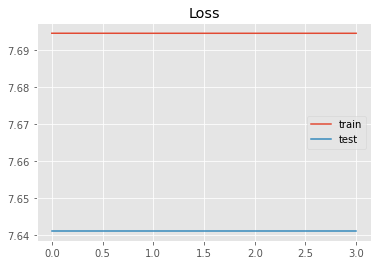

In [144]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

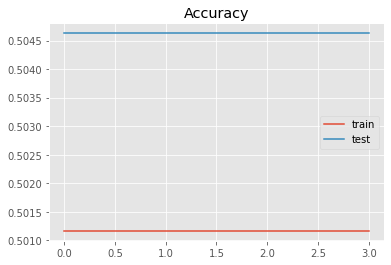

In [145]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Lenght of chunks 

In [106]:
test = pd.DataFrame(X_train_tech.reset_index(drop = True))
test['word_count'] = test['combined_words'].apply(lambda x: len(word_tokenize(x)))
test[:5]

,combined_words,word_count
0,learning models familiarity,3
1,knowhow,1
2,data processing technologies,3
3,health plan data,3
4,employment opportunity statement travelers,4


In [107]:
test.word_count.median()

2.0

In [108]:
test.word_count.mean()

2.3680297397769516

## Soft skills version: 20 vs 80 split


In [ ]:
X_train_soft, X_test_soft, y_train_soft, y_test_soft = train_test_split(df_chunk["combined_words"], df_chunk["Soft"], test_size=0.2, random_state=42)
X_train_soft.shape

vocab_size = 250000
encoded_docs_train_soft = [one_hot(d, vocab_size) for d in X_train_soft]

# pad documents to a max length of 4 words
max_length = 5
padded_docs_train_soft = pad_sequences(encoded_docs_train_soft, maxlen=max_length, padding='post')
print(padded_docs_train_soft)

encoded_docs_test_soft = [one_hot(d, vocab_size) for d in X_test_soft]

padded_docs_test_soft = pad_sequences(encoded_docs_test_soft, maxlen=max_length, padding='post')
#print(padded_docs_test)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

# fit the model
model.fit(padded_docs_train_soft, y_train_soft, epochs=20, verbose=0)

model_soft = model.fit(padded_docs_train_soft, y_train_soft, epochs=25, validation_data = (padded_docs_test_soft, y_test_soft), verbose=2)

#model.save('CNN_soft_may18_10pct.model')

prediction_soft = model.predict(padded_docs_test_soft)

df_soft= pd.DataFrame(X_test_soft)
df_soft["skill_soft"] = y_test_soft
df_soft["prediction"] = prediction_soft.round(0)
df_soft.shape

actual_values = df_soft.skill_soft.values
predicted_values = df_soft.prediction.values.astype(int)

confusion = confusion_matrix(actual_values, predicted_values)
print(confusion)

# Test full dataset

In [146]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 250000

MAX_SEQUENCE_LENGTH = 5

# This is the size of the vector space in which words will be embedded. 
# It defines the size of the output vectors from this layer for each word. 
EMBEDDING_DIM = 5

# This is the length of input sequences. 
#For example, if all of your input documents are comprised of 1000 words, this would be 1000.
INPUT_LENGTH = 5

#max_len = 1

lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=5, dropout=0.2))
lstm_model.add(SpatialDropout1D(0.2))

lstm_model.add(LSTM(100, recurrent_dropout=0.2, dropout=0.2))
lstm_model.add(Dense(max_len))
lstm_model.add(Activation('relu'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

lstm_model.summary()

/Users/pavel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 5, 5)              1250000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 5, 5)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 1,292,501
Trainable params: 1,292,501
Non-trainable params: 0
_________________________________________________________________


In [121]:
vocab_size = 250000
encoded_docs_train = [one_hot(d, vocab_size) for d in df_chunk_df_no_dups["combined_words"]]

In [122]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
print(padded_docs_train)

[[192866      0      0      0      0]
 [ 73967      0      0      0      0]
 [165343      0      0      0      0]
 ...
 [ 45381 149336 247078  40838      0]
 [227104  71587      0      0      0]
 [219345  24761 147270      0      0]]


In [147]:
prediction_full = lstm_model.predict(padded_docs_train)
prediction_full.shape

(35701, 1)

In [125]:
df_chunk_no_dups["prediction"] = prediction_full.round(2)
df_chunk_no_dups[:5]

,word_1,word_2,word_3,word_4,word_5,combined_words,prediction
0,research,,,,,research,0.01
1,analysis,,,,,analysis,0.01
2,patterns,,,,,patterns,0.01
3,data,,,,,data,0.01
4,methods,,,,,methods,0.01


In [127]:
df_skill_predict = df_chunk_no_dups[df_chunk_no_dups["prediction"] >= .8]
df_noskill_predict = df_chunk_no_dups[df_chunk_no_dups["prediction"] <= .2]

In [132]:
df_skill_predict[:10]

,word_1,word_2,word_3,word_4,word_5,combined_words,prediction


In [133]:
df_predict = pd.DataFrame(df_skill_predict.groupby(["combined_words", "prediction"]).count()["word_1"].sort_values(ascending = False)).reset_index().rename(columns = {'word_1' : "count"})

df_predict[:10]


,combined_words,prediction,count
